In [4]:
import functools
import math
import numpy as np
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

import matplotlib as plt
plt.rcParams['figure.figsize'] = (8,6)

from IPython.display import display

### Load Database

In [5]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [180]:
db = DB('earthfury-alliance', timerange=14)

In [181]:
item = 2840 # copper bar

### Percentile Functions

In [182]:
def pctBelowValue(series, value):
    return stats.percentileofscore(series, value)/100

def pctAboveValue(series, value):
    return 1-stats.percentileofscore(series, value)/100

def valueAtPctile(series, pctile):
    return series.quantile(pctile)
    

### Daily Rollups

In [183]:
def dailyMax(item, column='minBuyout'):
    # use 90 pctile instead of max() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.9)

def dailyMin(item, column='minBuyout'):
    # use 10 pctile instead of min() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.1)

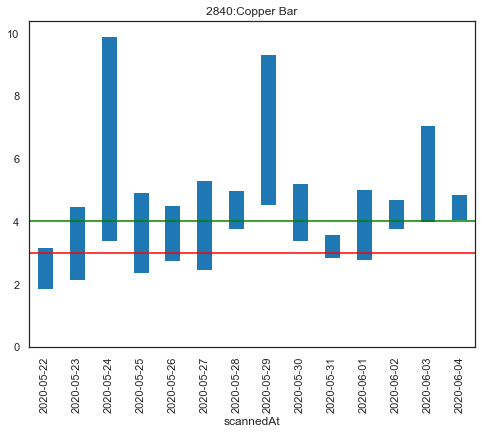

In [184]:
def plotDailyRange(item, buyAt=None, sellAt=None):
    title = f'{item}:{db.get_name(item)}'
        
    # create bars
    _, ax = plt.subplots()
    dailyMax(item).plot(kind='bar', x='scannedAt', y='minBuyout', title=title, ax=ax)
    dailyMin(item).plot(kind='bar', x='scannedAt', y='minBuyout', color='w', ax=ax)
    
    # add buy lines if passed
    if buyAt and sellAt:
        ax.axhline(y=buyAt, color='red')
        ax.axhline(y=sellAt, color='green')

    
plotDailyRange(item, 3, 4)

### Analysis

In [207]:
def postcost_at_salerate(item, salerate):
    if salerate == 0:
        return 0
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

def iterPrice(item):
    # iterate from min price to max price in .01 percentile steps
    for pctile in np.arange(0, 1, .01):
        yield db.get_df_hourly(item)['minBuyout'].quantile(pctile)

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi
82,12803,Living Essence,239.9986,0.428571,4.0,227.99867,141.259635,0.802469,94.738965,0.343915,32.582184,0.224303


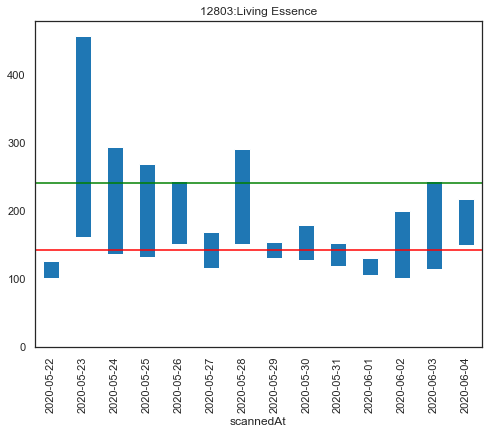

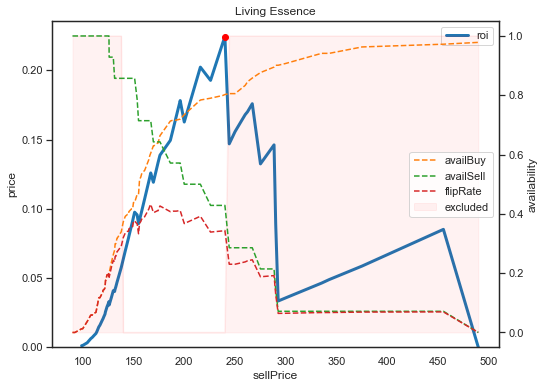

In [362]:
def analysis(item, show=False):
    columns = ['sellPrice', 'availSell', 'postCost', 'maxBuy', 'meanBuy', 'availBuy', 'value', 'timeValue', 'roi']
    data = []
    for sellPrice in iterPrice(item):
        availSell = pctAboveValue(dailyMax(item), sellPrice) # use dailyMax series due to selling pattern
        
        # low sale rates data is unreliable
#         if availSell<.3:
#             continue

        # expected posting cost based on avail sell
        postCost = postcost_at_salerate(item, availSell)

        # buying values
        maxBuy   = sellPrice * .95
        meanBuy  = db.get_df_hourly(item).query('minBuyout <= @maxBuy')['minBuyout'].mean()
        availBuy = pctBelowValue(db.get_df_hourly(item)['minBuyout'], maxBuy) # use hourly series due to buying pattern        

        # profit
        value = sellPrice - meanBuy - postCost
        timeValue = value * availSell * availBuy
        roi = timeValue / (meanBuy + postCost)        
        
        # load into data
        data.append({
            'item_id'  :item,
            'name'     :db.get_name(item),
            'sellPrice':sellPrice,
            'availSell':availSell, 
            'postCost' :postCost,
            'maxBuy'   :maxBuy, 
            'meanBuy'  :meanBuy,
            'availBuy' :availBuy,
            'value'    :value, 
            'flipRate' :availSell * availBuy,
            'timeValue':timeValue, 
            'roi'      :roi,        
        })
    
    # no data caused by 100% exclusion
    if data == []:
        print(f'{item}:{db.get_name(item)} excluded')
        return

    # data frame for analysis
    df = pd.DataFrame(data)    
    cutoff = .3 # only consider sell rates above X
    best = df.loc[df['roi'] == df.query('flipRate > @cutoff')['roi'].max()]
    if best.empty:
        # if no optimal found above cutoff, find best anyway
        best = df.loc[df['roi'] == df['roi'].max()]
    
    if show:
        # plot daily range and buy/sell lines
        display(best)
        plotDailyRange(item, best.iloc[0]['meanBuy'], best.iloc[0]['sellPrice'])
        
        # plot analysis curve
        _, ax = plt.subplots()
        df.plot(x='sellPrice', y=['roi'], title=db.get_name(item), linewidth=3, ax=ax)
        plt.plot(best['sellPrice'],best['roi'],'ro') 
        
        # create exclusion zone based on cutoff
        df['excluded'] = df['flipRate'].apply(lambda x: x<cutoff).astype(int)
        df.plot(kind='area', x='sellPrice', y='excluded', secondary_y=True, color='red', alpha=.05, ax=ax, legend=False)
        
        # plot roi and rates
        df.plot(x='sellPrice', y=['availBuy', 'availSell', 'flipRate'], style='--', secondary_y=True, ax=ax, legend=False).legend(loc='center right')
        ax.set_ylabel('price')
        ax.right_ax.set_ylabel('availability')
        return
    return best.to_dict('r')[0]
    
analysis(12803, show=True)

### Full Run

In [363]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  bags        : 38 items
  eng         : 53 items
  ALL         : 266 items
  CHOICE      : 70 items (quantity>100 and sellPrice>2.5s)



In [364]:
%%time

# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(CHOICE, analysis)

running for 70 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
COMPLETE
Wall time: 52.7 s


### Inspect Results

In [372]:
pd.set_option('display.max_rows', None)
choice = df.query('flipRate>.3 and sellPrice>3').sort_values(by='roi')
choice

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi
33,6037,Truesilver Bar,26.96,0.50,7.50,25.61,18.33,0.66,1.13,0.3300,0.37,0.01
21,14047,Runecloth,7.10,0.79,0.65,6.74,6.19,0.47,0.26,0.3713,0.10,0.01
20,4338,Mageweave Cloth,4.08,0.86,0.25,3.88,3.67,0.36,0.16,0.3096,0.05,0.01
37,12359,Thorium Bar,19.98,0.79,0.98,18.98,17.18,0.40,1.82,0.3160,0.58,0.03
3,8845,Ghost Mushroom,115.65,0.50,2.25,109.87,104.73,0.68,8.67,0.3400,2.93,0.03
67,7068,Elemental Fire,484.17,0.71,0.96,459.96,433.09,0.52,50.12,0.3692,18.78,0.04
66,7067,Elemental Earth,340.79,0.64,1.33,323.75,308.90,0.56,30.56,0.3584,10.91,0.04
55,9206,Elixir of Giants,135.00,0.79,1.15,128.25,119.68,0.38,14.17,0.3002,4.26,0.04
22,4305,Bolt of Silk Cloth,11.11,0.86,0.60,10.55,8.99,0.36,1.52,0.3096,0.47,0.05
45,16203,Greater Eternal Essence,560.48,0.43,0.00,532.45,489.11,0.80,71.37,0.3440,24.36,0.05


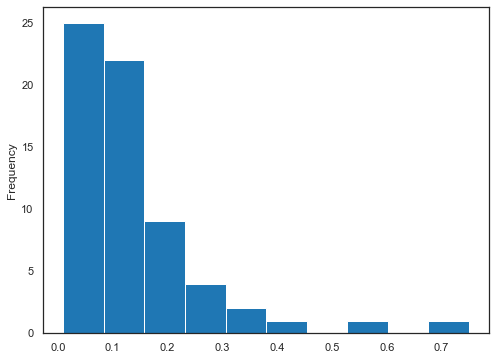

In [373]:
choice['roi'].plot(kind='hist')

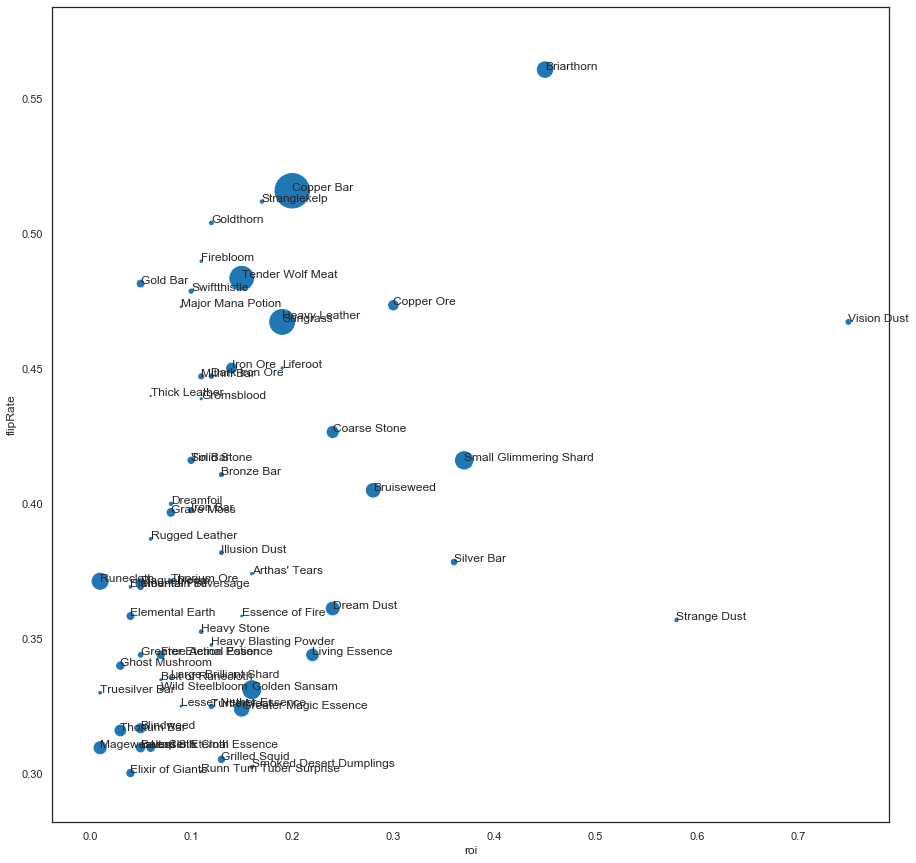

In [375]:
x = 'roi'
y = 'flipRate'
ax = choice.plot(kind='scatter', x=x, y=y, s=df['sellPrice'], figsize=(15,15))


for _, r in choice.iterrows():
    ax.text(r[x], r[y], r['name'])
    

### Export

In [298]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [299]:
e = df.copy()
# format for export (note, 100x to scale integer copper)
e['buy_price']    = 100 * e['sellPrice'] * .95 
e['min_price']    = 100 * e['sellPrice']
e['normal_price'] = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e['max_price']    = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e = e.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})

In [300]:
# restock=75 if item price is less than 1g, else stack_size=30
e['restock'] = e['sellPrice'].apply(lambda x: 75 if x < 100 else 30)

# stack_size=10 if item price is less than 1g, else stack_size=5
e['stack_size'] = e['sellPrice'].apply(lambda x: 10 if x < 100 else 5)

In [301]:
EXPORT(e)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SArthas' Tears^T^SaboveMax^SmaxPrice^SnormalPrice^S843^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S843^SignoreLowDuration^N0^SstackSize^N10^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S767^SkeepQtySources^T^t^Sblacklist^S^t^SPlaguebloom^T^SaboveMax^SmaxPrice^SnormalPrice^S28468^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S28468^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S25880^SkeepQtySources^T^t^Sblacklist^S^t^SMountain Silversage^T^SaboveMax^SmaxPrice^SnormalPrice^S16182^Sduration^N3^Smatch